# Cars Dataset

In [77]:
from collections import Counter
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image
import random
import scipy
from sklearn.linear_model import SGDClassifier
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import learning_curve
import time
from torchvision.models import resnet18, ResNet18_Weights
from torch.nn import Identity
from torchvision.io import read_image
from torchvision import transforms
import torch
from tqdm import tqdm

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data

The dataset should (be downloaded)[https://ai.stanford.edu/~jkrause/cars/car_dataset.html] and extracted into a `data/` folder at the project root.  

In [2]:
DATA_PATH = Path("data")

### TASK 1 - Build a function that converts a labelled dataset into labelled and unlabelled subsets.

In [3]:
def get_labelled_and_unlabelled_indexes(
    dataset_labels,
    proportion
):
    if 0 >= proportion >= 1:
        raise ValueError("`proportion` should be a float between 0 and 1.")

    split_index = int(len(dataset_labels) * (1 - proportion))
    unique_classes = np.unique(dataset_labels).tolist()
    
    if split_index < len(unique_classes):
        min_proportion = len(unique_classes) / len(dataset_labels)
        raise ValueError(
            f"The proportion should be greater than {min_proportion} to ensure" \
            "all unique classes have at least one instance labelled."
        )
        
    dataset_indexes = np.arange(0, len(dataset_labels))
    
    while True:
        random.shuffle(dataset_indexes)
    
        labelled_indexes = dataset_indexes[:split_index]
        unlabelled_indexes = dataset_indexes[split_index:]
    
        # Make sure at least one instance of each class is labelled
        if np.unique(np.array(dataset_labels)[labelled_indexes]).tolist() == unique_classes:
            break
    
    return labelled_indexes, unlabelled_indexes 

### TASK 2 - Data cleaning

In [116]:
def delete_non_RGB_images(image_path):
    delete_count = 0
    for filename in image_path.iterdir():
        image = Image.open(filename)
        if image.mode == "RGB":
            continue
            
        print(f"Deleting {filename} (is not an RGB image).")
        filename.unlink()
        delete_count += 1

    print(f">>> Deleted {delete_count} files in {image_path}.")

    
for image_path in [
    DATA_PATH / "cars_train", 
    DATA_PATH / "cars_test", 
]:
    delete_non_RGB_images(image_path)

Deleting data/cars_train/05713.jpg (is not an RGB image).
Deleting data/cars_train/03439.jpg (is not an RGB image).
Deleting data/cars_train/08144.jpg (is not an RGB image).
Deleting data/cars_train/05502.jpg (is not an RGB image).
Deleting data/cars_train/04848.jpg (is not an RGB image).
Deleting data/cars_train/03048.jpg (is not an RGB image).
Deleting data/cars_train/03539.jpg (is not an RGB image).
Deleting data/cars_train/07774.jpg (is not an RGB image).
Deleting data/cars_train/05177.jpg (is not an RGB image).
Deleting data/cars_train/08137.jpg (is not an RGB image).
Deleting data/cars_train/02176.jpg (is not an RGB image).
Deleting data/cars_train/01085.jpg (is not an RGB image).
Deleting data/cars_train/07383.jpg (is not an RGB image).
Deleting data/cars_train/03469.jpg (is not an RGB image).
Deleting data/cars_train/06947.jpg (is not an RGB image).
Deleting data/cars_train/00266.jpg (is not an RGB image).
Deleting data/cars_train/04577.jpg (is not an RGB image).
Deleting data/

### TASK 3 - Dataset representation

Here, we directly load images as pytorch tensors. We keep them in a dictionary where the image filename is the key and the tensor is the value.

In [4]:
def load_images(image_path):
    images = {}
    for filename in image_path.iterdir():
        # Directly load images as tensors
        images[filename.name] = read_image(str(filename))
    
    print(f"{len(images)} images in {image_path}.")
    
    return images    

train_images = load_images(DATA_PATH / "cars_train")

8126 images in data/cars_train.


We load the annotations and store them in a dictionnary where the image filename is the key and the classification is the value.

In [5]:
def load_annotation_files(filename):
    data = scipy.io.loadmat(filename)["annotations"][0]
    
    annotations = {}
    for d in data:
        image_filename = d[-1][0]
        _class = d[-2][0][0]
        
        annotations[image_filename] = _class
    
    return annotations
        
train_annotations = load_annotation_files(DATA_PATH / "devkit" / "cars_train_annos.mat")

Here, we load and print the corresponding classes. As we can see, classes are very granular. 

In [75]:
def load_annotation_metadata_files(filename):
    data = scipy.io.loadmat(filename)["class_names"][0]
    metadata = [d[0] for d in data]
    
    return metadata
    

metadata = load_annotation_metadata_files(DATA_PATH / "devkit" / "cars_meta.mat")
print(metadata)

['AM General Hummer SUV 2000', 'Acura RL Sedan 2012', 'Acura TL Sedan 2012', 'Acura TL Type-S 2008', 'Acura TSX Sedan 2012', 'Acura Integra Type R 2001', 'Acura ZDX Hatchback 2012', 'Aston Martin V8 Vantage Convertible 2012', 'Aston Martin V8 Vantage Coupe 2012', 'Aston Martin Virage Convertible 2012', 'Aston Martin Virage Coupe 2012', 'Audi RS 4 Convertible 2008', 'Audi A5 Coupe 2012', 'Audi TTS Coupe 2012', 'Audi R8 Coupe 2012', 'Audi V8 Sedan 1994', 'Audi 100 Sedan 1994', 'Audi 100 Wagon 1994', 'Audi TT Hatchback 2011', 'Audi S6 Sedan 2011', 'Audi S5 Convertible 2012', 'Audi S5 Coupe 2012', 'Audi S4 Sedan 2012', 'Audi S4 Sedan 2007', 'Audi TT RS Coupe 2012', 'BMW ActiveHybrid 5 Sedan 2012', 'BMW 1 Series Convertible 2012', 'BMW 1 Series Coupe 2012', 'BMW 3 Series Sedan 2012', 'BMW 3 Series Wagon 2012', 'BMW 6 Series Convertible 2007', 'BMW X5 SUV 2007', 'BMW X6 SUV 2012', 'BMW M3 Coupe 2012', 'BMW M5 Sedan 2010', 'BMW M6 Convertible 2010', 'BMW X3 SUV 2012', 'BMW Z4 Convertible 2012

We load a pretrained resnet18 with the default weights (ImageNet). We replace the last fully convolutional layer with a pass-trough layer and we set the model to evaluation mode.

In [119]:
def prepare_model():
    model = resnet18(weights=ResNet18_Weights.DEFAULT)
    # Replace last layer
    model.fc = Identity()
    
    return model.eval()

model = prepare_model()

For each image in the dataset, we apply transformations so that the input is similar to the ones the model has been trained on. We save the embedding in a dictionnary, along with the classification and a flag to indicate if the data point is labelled or not. 

We then save the result on disk.

In [6]:
def prepare_dataset(model, transform, images, annotations):
    dataset = {}
    for i, (image_filename, image) in enumerate(tqdm(images.items())):
        
        if image_filename not in annotations:
            print(image_filename)
            continue
        
        x = image / 256
        x = transform(x)
        x = x.float()
        x = x.unsqueeze(0)
        
        embedding = model(x).detach()
        embedding = embedding[0].numpy()
        
        dataset[i] = {
            "embedding": embedding, 
            "class_idx": annotations[image_filename], 
            "labelled": True
        }
        
    return dataset
    
dataset = prepare_dataset(
    model=model, 
    transform=ResNet18_Weights.DEFAULT.transforms(), 
    images=train_images, 
    annotations=train_annotations
)

torch.save(dataset, DATA_PATH / "dataset.pt")

# dataset = torch.load(DATA_PATH / "dataset.pt")

Inputing the right data transformation is key to produce consistent embedding using a pretrained network. And it's quite tricky to assess if your embedding is corrupted or not. Here, we simply proceed to a sanity check of the full resnet18 classification (with the original fc layer). We verify that the imagenet classification is consistent. We only check the first 50 samples.  

Here are the classes predicted by the model. We can conclude that the embedding is consistent and capture the nature of the input image as expected. 

- 436: beach wagon, station wagon, wagon, estate car, beach waggon, station wagg, waggon
- 468: cab, hack, taxi, taxicab
- 511: convertible
- 581: grille, radiator grille
- 609: jeep, landrover
- 627: limousine, limo
- 654: minibus
- 656: minivan
- 717: pickup, pickup truck
- 817: sports car, sport car
- 864: tow truck, tow car, wrecker

In [29]:
def embedding_sanity_check(transform, images):
    model = resnet18(weights=ResNet18_Weights.DEFAULT)
    model = model.eval()
    
    predictions = []
    for i, (image_filename, image) in enumerate(images.items()):
        
        x = image / 256
        x = transform(x)
        x = x.float()
        x = x.unsqueeze(0)
        
        image_net_classification = model(x).detach()[0]
        prediction = image_net_classification.argmax().item()
        predictions.append(prediction)
        
        if i == 50:
            break
    
    print(Counter(predictions))

embedding_sanity_check(
    transform=ResNet18_Weights.DEFAULT.transforms(), 
    images=train_images
)

Counter({817: 12, 656: 11, 436: 6, 511: 6, 717: 3, 581: 3, 468: 3, 627: 3, 654: 2, 609: 1, 864: 1})


### TASK 4 - Build a partially labelled dataset

In [30]:
def select_items(my_list, selected_indexes):
    selected_items = [
        item for i, item in enumerate(my_list) if i in selected_indexes
    ]
    
    return selected_items

dataset_inputs, dataset_labels = zip(*[
    (d["embedding"], d["class_idx"]) for d in dataset.values()
])
    
labelled_indexes, unlabelled_indexes = get_labelled_and_unlabelled_indexes(
    dataset_labels,
    0.6
)

dataset_inputs_labelled = select_items(dataset_inputs, labelled_indexes)
dataset_labels_labelled = select_items(dataset_labels, labelled_indexes)

print(f"{len(labelled_indexes)} labelled items ({round(len(labelled_indexes) / len(dataset_labels) * 100)})%")
print(f"{len(unlabelled_indexes)} unlabelled items ({round(len(unlabelled_indexes) / len(dataset_labels) * 100)})%")

3250 labelled items (40)%
4876 unlabelled items (60)%


### TASK 5 - Create train/validation split

Since data is already shuffled, we simply slice data based on the index that splits the data in the defined training proportion. 

In [8]:
def split_dataset(
    dataset_inputs,
    dataset_labels,
    training_proportion
):
    if 0 >= training_proportion >= 1:
        raise ValueError("`training_proportion` should be a float between 0 and 1.")
    
    index_split = int(len(dataset_inputs) * training_proportion)
    
    training_inputs = dataset_inputs[:index_split]
    training_labels = dataset_labels[:index_split]
    
    valid_inputs = dataset_inputs[index_split:]
    valid_labels = dataset_labels[index_split:]
    
    return training_inputs, training_labels, valid_inputs, valid_labels

### TASK 6 - Create experiment(s) to convince clients that more labelled data will improve model performance 

Here, we split our dataset into a training set (85% of the labelled data) and a validation set (15% of the labelled data). We then train a an SGD classifier, and return both the training and the validation score. Note that we also apply a Standard Scaler to our embedding before its passed to the model.

Here we have a hold out validation set. But we could have instead performed a cross-validation to use all of our labelled samples during training. 

In [67]:
def train_model(X_train, y_train, X_valid, y_valid, max_iteration=10000, verbose=0):
    classifier = make_pipeline(
        StandardScaler(),
        SGDClassifier(
            loss="modified_huber", 
            max_iter=max_iteration,  
            shuffle=True,
            tol=1e-4, 
            penalty="l2",
            verbose=verbose,
            class_weight="balanced",
            random_state=1
        )
    )
    
    t0 = time.time()
    classifier.fit(X_train, y_train)
    t1 = time.time()
    
    print(f"Classifier trained in {round(t1 - t0, 2)} seconds.")
    
    train_score = classifier.score(X_train, y_train)
    valid_score = classifier.score(X_valid, y_valid)
    
    return classifier, train_score, valid_score


X_train, y_train, X_valid, y_valid = split_dataset(
    dataset_inputs_labelled,
    dataset_labels_labelled,
    training_proportion=0.85
)

print(f"Train: {len(X_train)} samples ({round(len(X_train) / len(dataset_inputs) * 100)}% original dataset)")
print(f"Valid: {len(X_valid)} samples ({round(len(X_valid) / len(dataset_inputs) * 100)}% original dataset)\n")

classifier, train_score, valid_score = train_model(
    X_train, 
    y_train, 
    X_valid, 
    y_valid, 
    max_iteration=1000, 
    verbose=0
)
print(f"\nTraining score: {round(train_score, 3)}")
print(f"Validation score: {round(valid_score, 3)}")

Train: 2762 samples (34% original dataset)
Valid: 488 samples (6% original dataset)

Classifier trained in 8.39 seconds.

Training score: 0.96
Validation score: 0.18


Again, we perform another sanity check by comparing the performance of a dummy model to set a lower bound to the expected accuracy. The dummy model accuracy is below 1%. In comparison to this score, we can assume that our model is effectively learning _something_. 

In [78]:
def train_model(X_train, y_train, X_valid, y_valid, max_iteration=10000, verbose=0):
    classifier = DummyClassifier()
    classifier.fit(X_train, y_train)
    train_score = classifier.score(X_train, y_train)
    valid_score = classifier.score(X_valid, y_valid)
    
    return classifier, train_score, valid_score

classifier, train_score, valid_score = train_model(
    X_train, 
    y_train, 
    X_valid, 
    y_valid, 
    max_iteration=1000, 
    verbose=0
)
print(f"\nTraining score: {round(train_score, 3)}")
print(f"Validation score: {round(valid_score, 3)}")


Training score: 0.008
Validation score: 0.002


Here, we try to select the most important features based on the variance accross the whole dataset. The hypothesis is that the resnet18 embedding may have useless features to describe different type of cars since they are most likely similar in the embedding space. We try to reduce the input dimension so that the model can focus on relevent features. 

Unfortunately, this solution does not seem to be efficient here, since the validation score is even lower. 

In [70]:
minimal_variance = 0.15

features_variance = np.var(dataset_inputs, axis=0)
most_import_features_index = np.where(features_variance > minimal_variance)[0]
print(f"Selected {len(most_import_features_index)}/{len(features_variance)} features.\n")

X_train_reduced = [x[most_import_features_index] for x in X_train]
X_valid_reduced = [x[most_import_features_index] for x in X_valid]

classifier, train_score, valid_score = train_model(
    X_train_reduced, 
    y_train, 
    X_valid_reduced, 
    y_valid, 
    verbose=0
)
print(f"\nTraining score: {round(train_score, 3)}")
print(f"Validation score: {round(valid_score, 3)}")

Selected 390/512 features.

Classifier trained in 6.9 seconds.

Training score: 0.941
Validation score: 0.17


Finally, we train classifiers with an increasing number of samples and a static validation set. 

In [71]:
train_scores = []
valid_scores = []

train_sizes = [
    int(ratio * len(X_train)) for ratio in np.arange(0.2, 1, 0.2)
]

for n in train_sizes:
    classifier, train_score, valid_score = train_model(
        X_train[:n], 
        y_train[:n], 
        X_valid, 
        y_valid, 
        verbose=0
    )
    
    train_scores.append(train_score)
    valid_scores.append(valid_score)

Classifier trained in 0.72 seconds.
Classifier trained in 1.74 seconds.
Classifier trained in 3.34 seconds.
Classifier trained in 5.44 seconds.


We use the training and validation scores to produce a plot of our classifiers learning curve. More specifically, we observe the training (red) and validation (green) scores with an increasing number of training samples. Here, the training score curve shows that the classifier can effectively learn features from the training set. However, we observe a big gap between the training and validation curve. That gap indicates that the model is unable to generalize to unseen data. Still, we note that the validation score is increasing with additional training data. 

This could lead us to think that more data would help the model perform better on the validation set. 

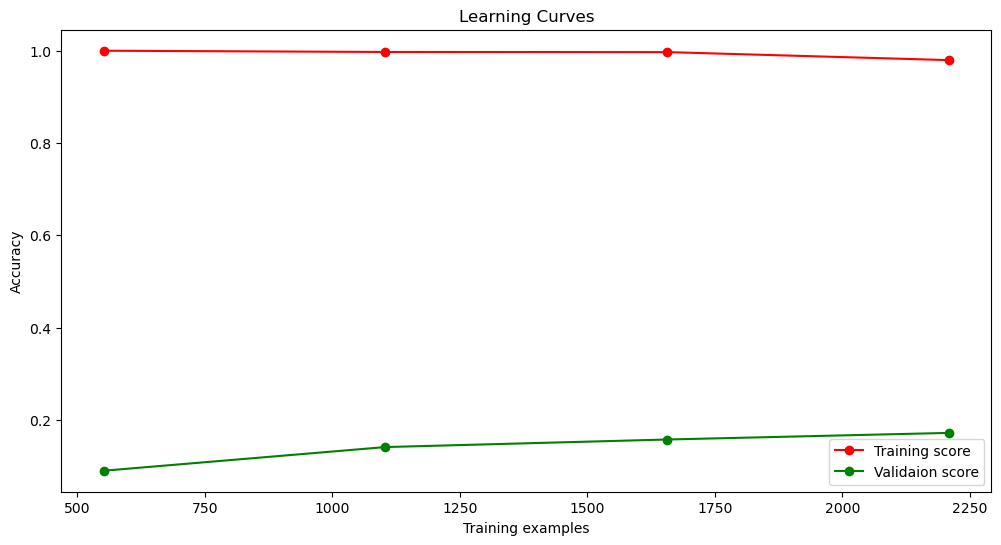

In [72]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(
    train_sizes, 
    train_scores, 
    label="Training score",
    marker="o", 
    color="r"
)
ax.plot(
    train_sizes, 
    valid_scores, 
    label="Validaion score", 
    marker="o", 
    color="g"
)
ax.set_xlabel("Training examples")
ax.set_ylabel("Accuracy")
ax.set_title("Learning Curves")
ax.legend(loc="best")

### TASK 7 - Active learning to select new instances to be labelled

In active learning, the goal is to select the most uncertain samples to be labelled. Here, we define the uncertainty as the entropy of the predition probability. If the the probability prediction have a high entropy, it means that the model is confused. 

Here, we directly selected the K most uncertain candidates according to our model trained on 40% of the original dataset. Active learning can also be done iteratively. One could select k (where k is smaller than K) candidates, retrain the classifier on the new dataset, and repeat the process with the newly trained classifier. However, incremental active learning is tedious to implement in practice, because you need to gather labels between each model runs. 

In [73]:
X_candidates = select_items(dataset_inputs, unlabelled_indexes)
y_candidates = select_items(dataset_labels, unlabelled_indexes)

K_candidates = int(len(dataset_inputs) * 0.25)

probabilities = classifier.predict_proba(X_candidates)
entropies = scipy.stats.entropy(probabilities, axis=1)

selected_candidate_indexes = np.argsort(entropies).tolist()[-K_candidates:]

print(f"Selected {K_candidates} new samples ({round(K_candidates / len(dataset_inputs) * 100)}% original dataset)")

Selected 2031 new samples (25% original dataset)


### TASK 8 - Final model training and evaluation

Here, we retrain our model on our original train set and the additional candidates selected with active learning. Our validation set remains the same so that we can compare the evolution over time. 

The final performance of our model is 21.3% of accuracy.

For any application, this level of performance is considered extremely poor. As as a result, we think that the decision to label more data was not a good one. 

However, this final score was to be expected.  Before the addition of data, the model performance was 17%. 
It is no surprise that labelling 25% more of the original dataset did not completely fill the gap of performance. It did helped improve the performance, but not did not bring it to a satisfactory level.

In fact, our learning curves indicate that the model is in an undefitting regime and that the model capacity is probably not sufficient to learn to classify the cars. 

Learning the very granular classes is indeed a very complex task. Also, the resnet18 might or might not contain such granular information. A more promising approach would be to finetune the entire resnet18 model pretrained on imagenet to produce by replacing the last fully convolutional layer to output our own set of classes. 

In [74]:
X_extra = select_items(dataset_inputs, selected_candidate_indexes)
y_extra = select_items(dataset_labels, selected_candidate_indexes)

X_final = X_train + X_extra
y_final = y_train + y_extra

print(f"Train: {len(X_final)} samples ({round(len(X_final) / len(dataset_inputs) * 100)}% original dataset)")
print(f"Valid: {len(X_valid)} samples ({round(len(X_valid) / len(dataset_inputs) * 100)}% original dataset)\n")

classifier, train_score, valid_score = train_model(
    X_final, 
    y_final, 
    X_valid, 
    y_valid, 
    verbose=0
)

print(f"FINAL TRAIN SCORE {round(train_score, 3)}")
print(f"FINAL VALID SCORE {round(valid_score, 3)}")

Train: 4793 samples (59% original dataset)
Valid: 488 samples (6% original dataset)

Classifier trained in 21.09 seconds.
FINAL TRAIN SCORE 0.898
FINAL VALID SCORE 0.213
